
Importing libraries

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import os

from mpl_toolkits.mplot3d import Axes3D
from time import time

# Set data type
DTYPE='float32'
#DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)
print('TensorFlow version used: {}'.format(tf.__version__))

TensorFlow version used: 2.15.0


In [2]:
# Final time
T = tf.constant(1., dtype=DTYPE)

# Spatial dimensions
dim = 2

# Domain-of-interest at t=0
a = 90 * tf.ones((dim), dtype=DTYPE)
b = 110 * tf.ones((dim), dtype=DTYPE)

# Interest rate
r = tf.constant(1./20, dtype=DTYPE)

# Drift
mu = tf.constant(0, dtype=DTYPE)

# Strike price
K = tf.constant(100., dtype=DTYPE)

# Diffusion/volatility
sigma = 1./10 + 1./200 * tf.range(1, dim+1, dtype=DTYPE)
#sigma = tf.constant([[0.1, 0.0],
#                     [-0.1, 0.1732051]], dtype=tf.float32)

# Correlation matrix between the brownien motions
correlation_matrix = tf.constant([[1.0, 0.5], [0.5, 1.0]], dtype=DTYPE) # this is just an example of the correlation matrix

# Define terminal condition, i.e., payoff at maturity
def fun_g(x):
    # Calculate the average price of the underlying asset
    average_price = tf.reduce_mean(x, axis=1, keepdims=True)


    return tf.exp(-r*T) * tf.maximum(average_price - K, 0.)


In [3]:
def init_model(dim, activation='tanh',
               num_hidden_neurons=100,
               num_hidden_layers=2,
               initializer=tf.keras.initializers.GlorotUniform()):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(dim))
    model.add(tf.keras.layers.BatchNormalization(epsilon=1e-6))
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_hidden_neurons,
                                activation=None,
                                use_bias=False,
                                kernel_initializer=initializer
                                ))
        model.add(tf.keras.layers.BatchNormalization(epsilon=1e-6))
        model.add(tf.keras.layers.Activation(activation))

    model.add(tf.keras.layers.Dense(1,
                                    activation=None,
                                    use_bias=False,
                                    kernel_initializer=initializer
                                    ))
    model.add(tf.keras.layers.BatchNormalization(epsilon=1e-6))

    return model

In [4]:
def loss_fn(X, y, model, training=False):
    """ This function computes the mean squared error between the current model
    prediction model(X) and the values y.
    Inputs:
        X - approximation to the state process X
        y - target value
        model - model of neural network approximating x -> u(T,x)
        training - boolean flag to indicate training
    """

    X0 = X[:,:,0]
    y_pred = model(X0, training)

    # Return mean squared error
    return tf.reduce_mean(tf.math.squared_difference(y, y_pred))

In [5]:
@tf.function
def compute_grad(X, y, model, training=False):
    """ This function computes the gradient of the loss function w.r.t.
    the trainable variables theta.
    Inputs:
        X - approximation to the state process X
        y - target value
        model - model of neural network approximating x -> u(T,x)
        training - boolean flag to indicate training
    """
    with tf.GradientTape() as tape:
        loss = loss_fn(X, y, model, training)
    grad = tape.gradient(loss, model.trainable_variables)
    return loss, grad

Generating Data

In [6]:

@tf.function
def draw_X(num_samples, a, b):
    """ Function to draw num_samples many pairs of uniformly drawn starting
    values X_0 and end points X_T of a stochastic process X with zero drift and
    constant scalar diffusion, now considering correlation. """
    dim = a.shape[0]

    # Generate initial points uniformly within [a, b]
    X0 = a + tf.random.uniform((num_samples, dim), dtype=DTYPE) * (b - a)

    # Generate independent standard normal variables
    xi = tf.random.normal(shape=(num_samples, dim), dtype=DTYPE)

    # Compute the Cholesky decomposition of the correlation matrix
    L = tf.linalg.cholesky(correlation_matrix)

    # Apply the Cholesky matrix to get correlated Brownian increments
    correlated_increments = tf.matmul(xi, L, transpose_b=True)

    # Calculate the end points of the processes
    XT = X0 *  tf.exp( (r - tf.square(sigma)/2) * T + sigma * tf.sqrt(T) * correlated_increments)

    # Return initial points and the end points
    return tf.stack([X0, XT], axis=2)







In [7]:
# Initialize model
model = init_model(dim=dim, num_hidden_neurons=dim+100, num_hidden_layers=3, activation='relu')

# Set up step size
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2501,5001],[1e-3,1e-4,1e-5])

# Set number of training epochs
num_epochs = 250000

# Set batch size
batch_size = 8192

# Choose an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8)

# Initialize list containing history of losses
hist_loss = []
error_hist = []

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# Model 1
# model = init_model(dim=dim, num_hidden_neurons=dim+50, num_hidden_layers=2, activation='relu')

# Model 2
#model_2 = init_model(dim=dim, num_hidden_neurons=dim+100, num_hidden_layers=4, activation='relu')

# Model 3
# model_3 = init_model(dim=dim, num_hidden_neurons=dim+100, num_hidden_layers=5, activation='sigmoid')

path = '/content/drive/My Drive/Weights_folder/OptionAsiatique'


model.load_weights(path)



In [8]:
from google.colab import drive

drive.mount('/content/drive')

path = '/content/drive/My Drive/Weights_folder/OptionAsiatique'




Mounted at /content/drive


Draw a test set with 250 000 samples and estimate the target values by means of Monte-Carlo estimation with $32 \times 32 000$ samples.

In [9]:
# Randomly choose a test set from \mathcal{D} to approximate
# errors by means of Monte Carlo sampling
n_test = 25000
X = draw_X(n_test, a, b)
Xtest = X[:,:,0]
Xtest = tf.convert_to_tensor(Xtest, dtype=DTYPE)
print(Xtest)
# Prepare Ytest
Ytest = tf.zeros((Xtest.shape[0],1),dtype=DTYPE)

# Determine values at Xtest through Monte-Carlo sampling
# Set batch size and mc_samples, results in b_size*mc_samples many iterates
b_size = 32
mc_samples = 3200


@tf.function
def mc_step(y):
    # Draw standard normal random variables
    Xi = tf.random.normal(shape=(b_size, dim), dtype=DTYPE)
    # Determine update
        # Compute the Cholesky decomposition of the correlation matrix
    L = tf.linalg.cholesky(correlation_matrix)

    # Apply the Cholesky matrix to get correlated Brownian increments
    correlated_increments = tf.matmul(Xi, L, transpose_b=True)

    upd = tf.exp( (r - tf.square(sigma)/2) * T + sigma * tf.sqrt(T) * correlated_increments)
    # Determine X_T
    XT = tf.reshape(Xtest, shape=[n_test, dim, 1])*tf.transpose(upd)
    return y + tf.reduce_sum(tf.reshape(fun_g(XT),[n_test, b_size]), axis=1,keepdims=True)/(b_size*mc_samples)

for i in range(mc_samples):
    if i%100==0:
         print(i,'/',mc_samples)
    Ytest=mc_step(Ytest)

print(Ytest)
####Other Method for generating Test Set
N = norm.cdf




tf.Tensor(
[[106.13316   98.09931 ]
 [108.08415  102.50682 ]
 [ 99.59955   91.01865 ]
 ...
 [ 95.21446  109.33937 ]
 [ 98.59929   96.61511 ]
 [107.579796 108.10188 ]], shape=(25000, 2), dtype=float32)
0 / 3200
100 / 3200
200 / 3200
300 / 3200
400 / 3200
500 / 3200
600 / 3200
700 / 3200
800 / 3200
900 / 3200
1000 / 3200
1100 / 3200
1200 / 3200
1300 / 3200
1400 / 3200
1500 / 3200
1600 / 3200
1700 / 3200
1800 / 3200
1900 / 3200
2000 / 3200
2100 / 3200
2200 / 3200
2300 / 3200
2400 / 3200
2500 / 3200
2600 / 3200
2700 / 3200
2800 / 3200
2900 / 3200
3000 / 3200
3100 / 3200
tf.Tensor(
[[ 8.17924  ]
 [10.83085  ]
 [ 3.6389983]
 ...
 [ 8.317229 ]
 [ 4.9686165]
 [13.115681 ]], shape=(25000, 1), dtype=float32)


In [10]:
# Define a training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Draw batch of random paths
    X = draw_X(batch_size, a, b)



    # Evaluate g at X_T
    y = fun_g(X[:,:,-1])

    # And compute the loss as well as the gradient
    loss, grad = compute_grad(X, y, model, training=True)
    #hist_loss.append(loss)

    # Perform gradient step
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

# Start timer
t0 = time()


# Set interval to estimate errors
log_interval = 1000

num_epochs = 500001
# Initialize header of output
print('  Iter        Loss   L1_rel   L2_rel   Linf_rel |   L1_abs   L2_abs   Linf_abs  |    Time')
# Loop to train model
for i in range(num_epochs):

    # Perform training step
    loss = train_step()
    hist_loss.append(loss)

    if i % log_interval == 0:

        # Compute current prediction on test set
        Ypred = model(Xtest, training=False)

        # Compute absolute and relative errors
        abs_error = np.abs(Ypred - Ytest)
        rel_error = abs_error/Ytest
        L2_rel = tf.sqrt(tf.reduce_mean(tf.pow(rel_error, 2))).numpy()
        L1_rel = tf.reduce_mean(tf.abs(rel_error)).numpy()
        Linf_rel = tf.reduce_max(tf.abs(rel_error)).numpy()

        L2_abs = tf.sqrt(tf.reduce_mean(tf.pow(abs_error, 2))).numpy()
        L1_abs = tf.reduce_mean(tf.abs(abs_error)).numpy()
        Linf_abs = tf.reduce_max(tf.abs(abs_error)).numpy()

        total_time = time()-t0
        err = (i, loss.numpy(), L1_rel, L2_rel, Linf_rel, L1_abs, L2_abs, Linf_abs, total_time)
        error_hist.append(err)

        print('{:5d} {:12.4f} {:8.4f} {:8.4f}   {:8.4f} | {:8.4f} {:8.4f}   {:8.4f}  |  {:6.1f}'.format(*err))

model.save_weights(path)
#Y = model.call((X,dw))
print(time()-t0)


  Iter        Loss   L1_rel   L2_rel   Linf_rel |   L1_abs   L2_abs   Linf_abs  |    Time
    0     110.5050   2.1711   2.2453     4.9915 |  13.5474  13.9137    22.4187  |     6.0
 1000      88.4626   0.9913   1.0626     2.9864 |   5.8974   5.9572     8.2348  |    11.2
 2000      77.6179   0.8662   0.9552     2.9263 |   4.9606   4.9686     5.6344  |    15.0
 3000      74.7865   0.7965   0.8851     2.8028 |   4.5349   4.5403     5.2257  |    18.9
 4000      73.3477   0.7826   0.8733     2.8031 |   4.4376   4.4414     5.0199  |    24.1
 5000      69.6541   0.7688   0.8654     2.8531 |   4.3199   4.3210     4.6231  |    27.9
 6000      68.0040   0.7671   0.8610     2.8134 |   4.3228   4.3243     4.6633  |    31.7
 7000      72.2690   0.7660   0.8603     2.8122 |   4.3131   4.3145     4.6377  |    36.8
 8000      72.8985   0.7645   0.8587     2.8004 |   4.3031   4.3044     4.6204  |    40.9
 9000      69.7639   0.7627   0.8577     2.8006 |   4.2887   4.2897     4.6143  |    44.8
10000     

In [11]:

final_error = []


In [12]:
final_error += error_hist

In [13]:
print(len(final_error))

501


In [14]:
model.save_weights(path)

Text(0, 0.5, 'training loss')

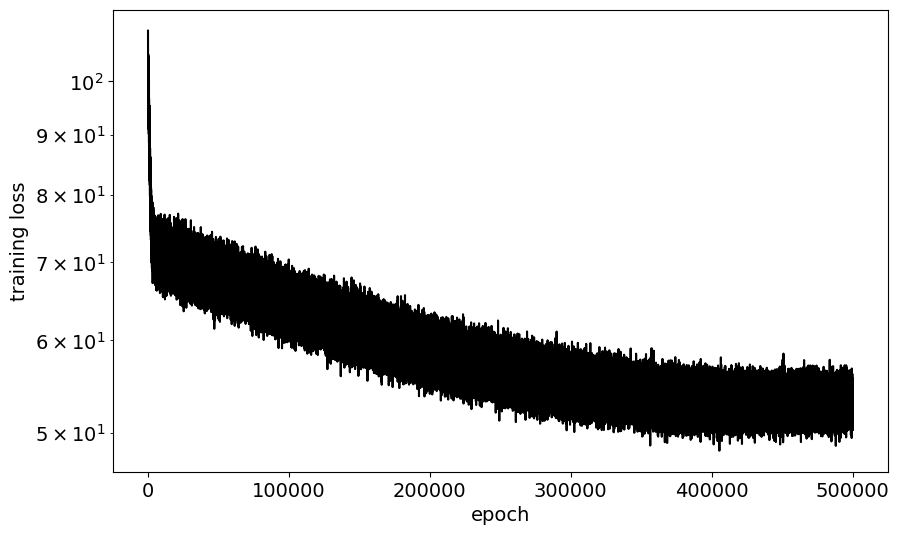

In [15]:
  # Drawing the loss history
  plt.rcParams.update({'font.size': 14})

  fig, ax = plt.subplots(1,1,figsize=(10,6))
  ax.semilogy(range(len(hist_loss)), hist_loss,'k-')
  ax.set_xlabel('epoch')
  ax.set_ylabel('training loss')

(<matplotlib.legend.Legend at 0x7afb8f82c940>,)

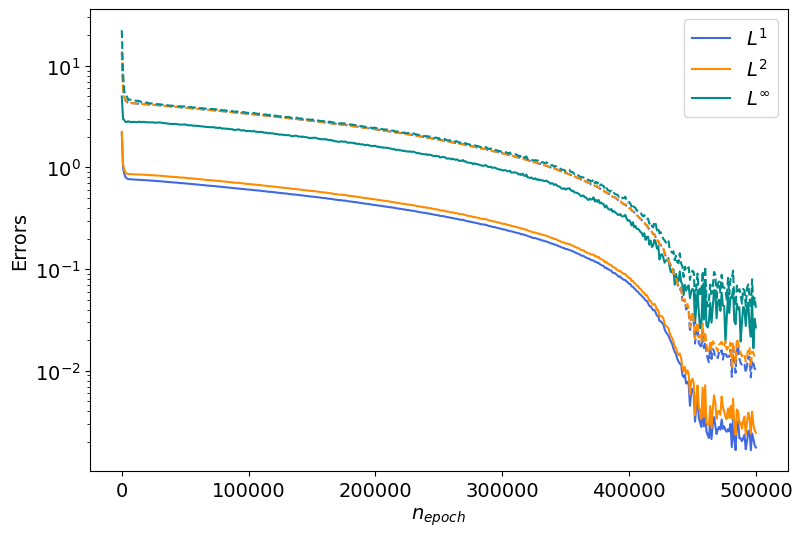

In [16]:
fig, ax = plt.subplots(1,1,figsize=(9,6))
ax.set_prop_cycle(color=['royalblue', 'darkorange', 'darkcyan'])
start_idx = 0
xrange = [e[0] for e in error_hist[start_idx:]]
ax.semilogy(xrange, [e[2:5] for e in error_hist[start_idx:]])
ax.semilogy(xrange, [e[5:8] for e in error_hist[start_idx:]], linestyle='--')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('Errors')
ax.legend(['$L^1$', '$L^2$', '$L^{\infty}$']),
#plt.savefig('Errors_HeatEquation_dim_{:03d}_{:s}.pdf'.format(dim,suffix), bbox_inches='tight', dpi=300)

5000/5000 [==============================] - 13s 2ms/step


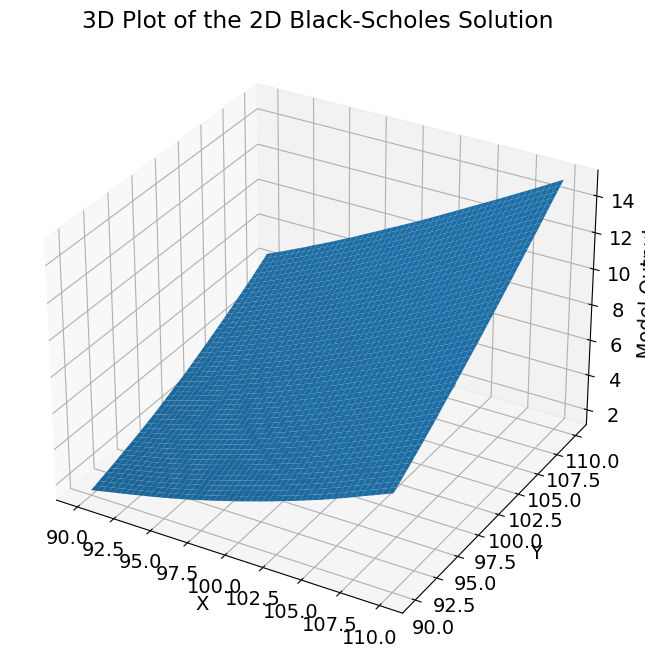

In [17]:
# Generate test data within the range [a, b]
x = np.linspace(a.numpy()[0], b.numpy()[0], 400)
y = np.linspace(a.numpy()[1], b.numpy()[1], 400)
X, Y = np.meshgrid(x, y)
Z = np.column_stack([X.ravel(), Y.ravel()])

# Predict using the model
predictions = model.predict(Z).reshape(X.shape)

# Plotting as a 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X, Y, predictions)  # Using a single color for the surface
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Model Output')
ax.set_title('3D Plot of the 2D Black-Scholes Solution')
plt.show()

782/782 [==============================] - 4s 5ms/step


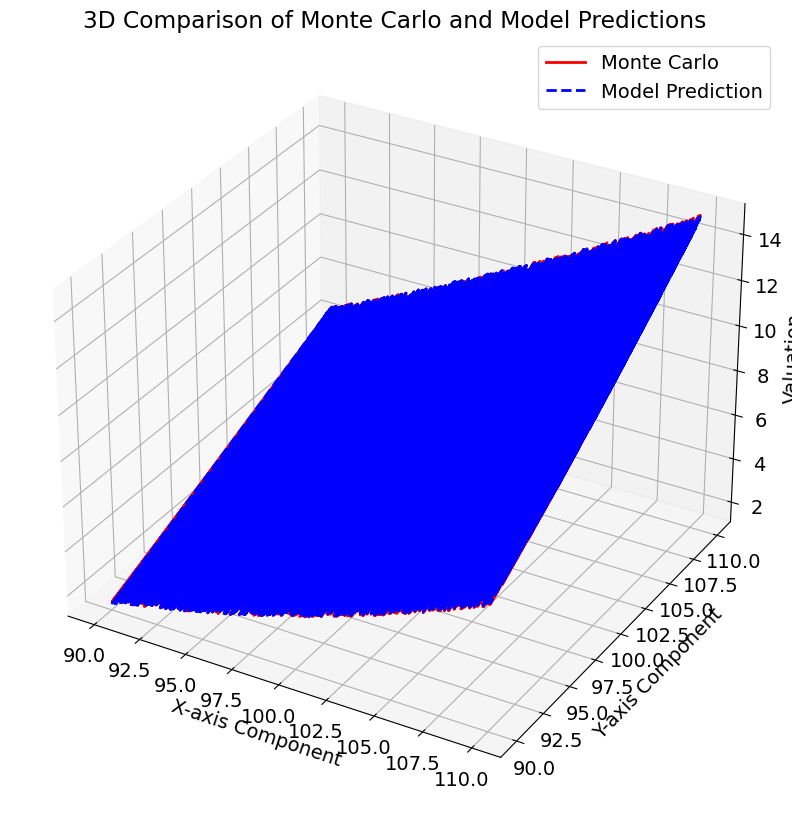

In [ ]:
Ymodel = model.predict(Xtest)


# Convert TensorFlow tensors to NumPy arrays for easier manipulation
Xtest_np = Xtest.numpy() if isinstance(Xtest, tf.Tensor) else Xtest
Ytest_np = Ytest.numpy().flatten() if isinstance(Ytest, tf.Tensor) else Ytest.flatten()
Ymodel_np = Ymodel.flatten()

# Extracting separate components from Xtest for plotting
X_axis = Xtest_np[:, 0]  # Assuming Xtest is 2D and we're using the first component for X-axis
Y_axis = Xtest_np[:, 1]  # Using the second component for Y-axis

# Sorting indices for plotting clarity (if necessary)
sorted_indices = np.lexsort((Y_axis, X_axis))  # Sort by X then by Y
X_axis_sorted = X_axis[sorted_indices]
Y_axis_sorted = Y_axis[sorted_indices]
Ytest_sorted = Ytest_np[sorted_indices]
Ymodel_sorted = Ymodel_np[sorted_indices]

# Creating the plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotting Monte Carlo results
ax.plot(X_axis_sorted, Y_axis_sorted, Ytest_sorted, label='Monte Carlo', color='red', linewidth=2)

# Plotting Model Predictions
ax.plot(X_axis_sorted, Y_axis_sorted, Ymodel_sorted, label='Model Prediction', linestyle='--', color='blue', linewidth=2)

# Adding labels and title
ax.set_xlabel('X-axis Component')
ax.set_ylabel('Y-axis Component')
ax.set_zlabel('Valuation')
ax.set_title('3D Comparison of Monte Carlo and Model Predictions')

# Adding a legend
ax.legend()

# Show the plot
plt.show()